I'm a beginner, so please be gentle with me.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import os
os.chdir('/content/drive/My Drive/colab_data/TPS2205/input')


In [ ]:
%%capture
!pip install pytorch-tabnet

# DataSet & Library Loading

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import time, gc

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler

In [ ]:
class CFG:
    batch_size = 8_192*8
    virtual_batch_size = 1_024
    epochs = 10_000  # 最大のepoch数
    folds = 10  # クロスバリデーションにおけるfold数
    seed = 42  # TODO 機能させる
    target = 'target'  # 目標変数
    model_path = "models"  # モデルを保存するフォルダ
    test_pred = []  # 各foldで作ったモデル別の、testを予測した結果のカラム名
    pred = 'pred'  # trainを予測した結果のカラム名
    increase_batch = 9999  # 何epoch間lossが改善しなかったbatchを増やすか
    early_stopping = 100  # 何epochでearly stoppingをするか
    lr = 1e-1  # optimizerの学習率
    min_lr = 1e-3  # 学習率の最低値
    lr_patience = 10  # 学習率を引き下げる間隔
    lr_factor = 0.5  # lrを何倍にするか  # TODO:たぶん消していい
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # TODO:たぶん消していい
    delta = 1e-4  # AUC等がいくつ変わらなかったら学習などをやめるか

In [ ]:
os.makedirs(CFG.model_path, exist_ok=True)

## FE

In [ ]:
print('FE')

FE


In [ ]:
# データセット読み込み
df_train = pd.read_csv("../input/tabular-playground-series-may-2022/train.csv")
df_test = pd.read_csv("../input/tabular-playground-series-may-2022/test.csv")
df_sub = pd.read_csv("../input/tabular-playground-series-may-2022/sample_submission.csv")
display(df_train.head())
display(df_test.head())
display(df_sub.head())

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,...,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,...,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,...,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30
0,900000,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,...,-1.006400,-1.193879,-2.435736,-2.427430,-1.966887,5.734205,BAAABADLAC,99.478419,0,0
1,900001,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,...,2.382405,0.149442,1.883322,-2.848714,-0.725155,3.194219,AFABBAEGCB,-65.993825,1,0
2,900002,0.303990,2.445110,0.246515,0.818248,0.359731,-1.331845,1.358622,3,3,...,-7.026098,1.312277,-5.157192,1.714005,0.585032,0.066898,BBACABBKEE,-87.405622,0,1
3,900003,0.154053,0.260126,-1.367092,-0.093175,-1.111034,-0.948481,1.119220,0,0,...,-0.594532,-3.939475,1.754570,-2.364007,-1.003320,3.893099,AEBEAACQCC,-281.293460,0,0
4,900004,-1.651904,-0.424266,-0.667356,-0.322124,-0.089462,0.181705,1.784983,2,2,...,0.084906,-0.985736,-0.130467,-3.557893,1.210687,1.861884,AEBBBBDABF,25.629415,0,2


,id,target
0,900000,0.5
1,900001,0.5
2,900002,0.5
3,900003,0.5
4,900004,0.5


In [ ]:
display(df_train.shape)
display(df_test.shape)

(900000, 33)

(700000, 32)

In [ ]:
df_all = pd.concat([df_train, df_test])

In [ ]:
df_all['i_02_21'] = (df_all.f_21 + df_all.f_02 > 5.2).astype(int) - (df_all.f_21 + df_all.f_02 < -5.3).astype(int)
df_all['i_05_22'] = (df_all.f_22 + df_all.f_05 > 5.1).astype(int) - (df_all.f_22 + df_all.f_05 < -5.4).astype(int)
i_00_01_26 = df_all.f_00 + df_all.f_01 + df_all.f_26
df_all['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)

In [ ]:
# 不要データを削除
df_all.drop(['id'], axis=1, inplace=True)

In [ ]:
# NA埋め
df_all.fillna(df_all.mean(numeric_only=True), inplace=True)

In [ ]:
# f_27を分解
def splitter(text):
    arr = tuple(text)
    return arr

column_list = ['f_27_' + str(i) for i in range(10)]
df_all[column_list] = df_all.apply(lambda x: splitter(x['f_27']), axis=1, result_type='expand')

In [ ]:
# f_27_0~9を数値に
for column in column_list:
    df_all[column] = df_all[column].apply(lambda x: ord(x)-ord('A'))

In [ ]:
# f_27_0~9の各種統計量を求める

df_all['f_27_mean'] =  df_all[column_list].mean(axis=1)
df_all['f_27_std'] =  df_all[column_list].std(axis=1)
df_all['f_27_sm'] = df_all['f_27_std'] / (df_all['f_27_mean']+0.001)


In [ ]:
# f_27に出てくる文字が、何種類あるかを返す
def calc_cnt_of(txt):
    from collections import Counter
    cnt_of = Counter(list(txt))
    return len(cnt_of)

df_all['len_cnt_of'] = df_all['f_27'].apply(calc_cnt_of)

In [ ]:
# f_27に各文字が何回出てくるかを数える
# これは明らかにカテゴリ変数ではないので、floatで管理する
def calc_char_cnt(txt):
    from collections import Counter
    import string
    cnt_of = Counter(list(txt))
    ret = []
    for c in string.ascii_uppercase:
        ret.append(float(cnt_of[c]))
    return tuple(ret)

import string
column_list = []
for c in string.ascii_uppercase:
    column_list.append('f_27_cnt_' + c)

df_all[column_list] = df_all.apply(lambda x: calc_char_cnt(x['f_27']), axis=1, result_type='expand')

In [ ]:
# 不要になったカテゴリ変数を削除
df_all.drop(['f_27'], axis=1, inplace=True)

In [ ]:
# カテゴリ変数を0-indexedに変換
categorical_columns = []
categorical_dims =  {}
from sklearn.preprocessing import LabelEncoder
for col in df_all.columns:
    if col == CFG.target:
        continue
    # if df_all[col].dtype == 'object' or len(df_all[col].unique()) < 200:
    if df_all[col].dtype == 'object' or df_all[col].dtype == 'int64':
        print(col, df_all[col].nunique())
        l_enc = LabelEncoder()
        df_all[col] = l_enc.fit_transform(df_all[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)


f_07 17
f_08 16
f_09 16
f_10 16
f_11 15
f_12 17
f_13 14
f_14 14
f_15 15
f_16 16
f_17 15
f_18 14
f_29 2
f_30 3
i_02_21 3
i_05_22 3
i_00_01_26 3
f_27_0 2
f_27_1 15
f_27_2 2
f_27_3 15
f_27_4 15
f_27_5 2
f_27_6 15
f_27_7 20
f_27_8 15
f_27_9 15
len_cnt_of 9


In [ ]:
unused_feat = []

features = [ col for col in df_all.columns if col not in unused_feat+[CFG.target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [ ]:
# ここまででFEは完了
# 省メモリ化
for col in df_all.columns:
    if df_all[col].dtype == 'float64':
        df_all[col] = df_all[col].astype('float32')
    elif df_all[col].dtype == 'int64':
        absmax = df_all[col].abs().max()
        print(col)
        print(absmax)
        if absmax < (1 << 7):
            df_all[col] = df_all[col].astype('int8')
        elif absmax < (1 << 15):
            df_all[col] = df_all[col].astype('int16')
        elif absmax < (1 << 31):
            df_all[col] = df_all[col].astype('int32')

f_07
16
f_08
15
f_09
15
f_10
15
f_11
14
f_12
16
f_13
13
f_14
13
f_15
14
f_16
15
f_17
14
f_18
13
f_29
1
f_30
2
i_02_21
2
i_05_22
2
i_00_01_26
2
f_27_0
1
f_27_1
14
f_27_2
1
f_27_3
14
f_27_4
14
f_27_5
1
f_27_6
14
f_27_7
19
f_27_8
14
f_27_9
14
len_cnt_of
8


In [ ]:
df_all.dtypes

f_00          float32
f_01          float32
f_02          float32
f_03          float32
f_04          float32
               ...   
f_27_cnt_V    float32
f_27_cnt_W    float32
f_27_cnt_X    float32
f_27_cnt_Y    float32
f_27_cnt_Z    float32
Length: 74, dtype: object

In [ ]:

all_features = df_all.columns.tolist()
all_features.remove(CFG.target)
df_all.reindex(all_features + [CFG.target], axis=1)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_27_cnt_R,f_27_cnt_S,f_27_cnt_T,f_27_cnt_U,f_27_cnt_V,f_27_cnt_W,f_27_cnt_X,f_27_cnt_Y,f_27_cnt_Z,target
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,0.640110,0.897808,-0.523956,1.563760,-0.092281,-0.610867,0.535426,0,1,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.486488
699996,-0.191771,-0.035246,-0.118533,0.584750,2.126976,0.568659,-0.052663,4,3,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.486488
699997,-0.331704,-0.328845,-1.185503,1.022128,-0.483099,-0.107146,-0.968281,1,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.486488
699998,-2.031073,-1.238398,0.964699,-1.045950,0.906064,0.634301,-0.707474,5,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.486488


In [ ]:
df_train = df_all[:len(df_train)]
df_test = df_all[len(df_train):]

In [ ]:
df_train.to_pickle('train_fe.pkl')
df_test.to_pickle('test_fe.pkl')
df_all.to_pickle('all_fe.pkl')

## TabNet

In [ ]:
print('TabNet')

TabNet


In [ ]:
df_train = pd.read_pickle('train_fe.pkl')
df_test = pd.read_pickle('test_fe.pkl')

## Define Pytorch Model

# Pytorch Loss Function

In [ ]:
criterion = nn.BCEWithLogitsLoss()

# Pytorch Training

In [ ]:
class LossChecker:
    # 指定した回数、loss等が改善されていなければTrueを返す
    def __init__(self, patience=20, strategy="min", delta=1e-6):
        self.patience = patience
        self.bef_epoch = 0
        self.strategy = strategy
        self.delta = delta
        if strategy == "max":
            self.val = -float('inf')
        else:
            self.val = float('inf')

    def step(self, epoch, loss):
        if self.strategy == "max":
            if self.val < loss:
                self.val = loss + self.delta
                self.bef_epoch = epoch
            if epoch - self.bef_epoch > self.patience:
                self.bef_epoch = epoch
                return True
            else:
                return False
        else:
            if self.val > loss:
                self.val = loss - self.delta
                self.bef_epoch = epoch
            if epoch - self.bef_epoch > self.patience:
                self.bef_epoch = epoch
                return True
            else:
                return False


In [ ]:
# 学習の対象とする特徴量を列挙する
all_features = df_train.columns.tolist()
all_features.remove(CFG.target)

In [ ]:
df_train.shape

(900000, 74)

In [ ]:
for i, d in zip(cat_idxs, cat_dims):
    print(i, d)

7 17
8 16
9 16
10 16
11 15
12 17
13 14
14 14
15 15
16 16
17 15
18 14
28 2
29 3
30 3
31 3
32 3
33 2
34 15
35 2
36 15
37 15
38 2
39 15
40 20
41 15
42 15
46 9


In [ ]:
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier

In [ ]:
CFG.batch_size

65536

In [ ]:
df_train = df_train.sample(frac=1).reset_index(drop=True)  # df_trainをシャッフル

skf = StratifiedKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)

for fold, (train_index, valid_index) in enumerate(skf.split(df_train, df_train[CFG.target])):
    print('-----', fold, '-----')

    X_train = df_train[all_features].to_numpy()[train_index]
    y_train = df_train[CFG.target].to_numpy()[train_index]
    X_valid = df_train[all_features].to_numpy()[valid_index]
    y_valid = df_train[CFG.target].to_numpy()[valid_index]
    X_test = df_test[all_features].to_numpy()
    
    # fold毎に初期化する設定
    # https://github.com/dreamquark-ai/tabnet
    tabnet_params = dict(
        # TODO ここら辺初期値にしてみる
        n_d=64,  # Width of the decision prediction layer. Bigger values gives more capacity to the model with the risk of overfitting. Values typically range from 8 to 64.
        n_a=64,  # Width of the attention embedding for each mask. According to the paper n_d=n_a is usually a good choice. (default=8)
        n_steps=5,  # Number of steps in the architecture (usually between 3 and 10)
        gamma=1.3,  # This is the coefficient for feature reusage in the masks. A value close to 1 will make mask selection least correlated between layers. Values range from 1.0 to 2.0.
        cat_idxs=cat_idxs, # list of int (default=[] - Mandatory for embeddings). List of categorical features indices.
        cat_dims=cat_dims,  # list of int (default=[] - Mandatory for embeddings). List of categorical features number of modalities (number of unique values for a categorical feature) /!\ no new modalities can be predicted
        cat_emb_dim=2,  # list of int (optional). List of embeddings size for each categorical features. (default =1)
        n_independent=3,  # Number of independent Gated Linear Units layers at each step. Usual values range from 1 to 5.
        n_shared=3,  # Number of shared Gated Linear Units at each step Usual values range from 1 to 5.
        # epsilon=1e-15   # Should be left untouched.
        seed=CFG.seed,
        momentum=0.01,  # Momentum for batch normalization, typically ranges from 0.01 to 0.4 (default=0.02)
        clip_value=None,  # float (default None). If a float is given this will clip the gradient at clip_value.
        lambda_sparse=1e-6,  # float (default = 1e-3). This is the extra sparsity loss coefficient as proposed in the original paper. The bigger this coefficient is, the sparser your model will be in terms of feature selection. Depending on the difficulty of your problem, reducing this value could help.

        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(
            lr=CFG.lr,
            weight_decay=1e-7
        ),
        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
        scheduler_params=dict(
            mode='max',
            factor=0.9,
            patience=10,
            min_lr=CFG.min_lr,
        ),
        verbose=1,  # Verbosity for notebooks plots, set to 1 to see every epoch, 0 to get None.
        device_name='auto',  #  str (default='auto') 'cpu' for cpu training, 'gpu' for gpu training, 'auto' to automatically detect gpu
        mask_type='sparsemax',  # (default='sparsemax') Either "sparsemax" or "entmax" : this is the masking function to use for selecting features.
    )

    print('unsupervised_model')
    unsupervised_model = TabNetPretrainer(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=2,
        optimizer_fn=torch.optim.Adam,
        device_name='auto',  #  str (default='auto') 'cpu' for cpu training, 'gpu' for gpu training, 'auto' to automatically detect gpu
        seed=CFG.seed,
    )  # schedulerとかがうまくいかないので、tabnet_paramsは使わないでみる

    unsupervised_model.fit(
        X_train=X_train,
        eval_set=[X_valid],
        pretraining_ratio=0.8,
        batch_size=CFG.batch_size,
        virtual_batch_size=CFG.virtual_batch_size,
        patience=20,
        max_epochs=CFG.epochs,
        pin_memory=True,
        num_workers=2,
    )

    print('main model')
    # Defining TabNet model
    model = TabNetClassifier(**tabnet_params)
    model.fit(
        X_train=X_train,
        y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=["train", "valid"],
        eval_metric=["auc"],
        batch_size=CFG.batch_size,
        virtual_batch_size=CFG.virtual_batch_size,
        max_epochs=CFG.epochs,
        drop_last=True,
        pin_memory=True,
        patience=20,
        num_workers=2,
        from_unsupervised=unsupervised_model,
        # weights=1,  # サンプリングするか否かっポイ default:0  # TODO weights=0の時との挙動の違いを見たい
    )
    df_train.loc[valid_index, CFG.pred] = model.predict_proba(X_valid)[:, -1]
    auc = roc_auc_score(y_true=y_valid, y_score=df_train.loc[valid_index, CFG.pred])
    print('AUC:', auc)
    df_test[CFG.pred + str(fold)] = model.predict_proba(X_test)[:, -1]

    # TEST
    # print('----- this is test run -----')
    # break

----- 0 -----
unsupervised_model
Device used : cuda
epoch 0  | loss: 17474242.26211| val_0_unsup_loss: 8379.45605|  0:00:05s
epoch 1  | loss: 5896.30275| val_0_unsup_loss: 2.85878 |  0:00:10s
epoch 2  | loss: 61.46923| val_0_unsup_loss: 2.06963 |  0:00:15s
epoch 3  | loss: 3.09758 | val_0_unsup_loss: 1.70161 |  0:00:21s
epoch 4  | loss: 3.03843 | val_0_unsup_loss: 1.52393 |  0:00:26s
epoch 5  | loss: 1.50813 | val_0_unsup_loss: 1.42851 |  0:00:31s
epoch 6  | loss: 1.43492 | val_0_unsup_loss: 1.38388 |  0:00:36s
epoch 7  | loss: 1.37347 | val_0_unsup_loss: 1.36601 |  0:00:41s
epoch 8  | loss: 2.09621 | val_0_unsup_loss: 1.36214 |  0:00:47s
epoch 9  | loss: 1.37853 | val_0_unsup_loss: 1.3592  |  0:00:52s
epoch 10 | loss: 2.17099 | val_0_unsup_loss: 1.35871 |  0:00:57s
epoch 11 | loss: 14.1903 | val_0_unsup_loss: 1.35858 |  0:01:02s
epoch 12 | loss: 1.35724 | val_0_unsup_loss: 1.35633 |  0:01:07s
epoch 13 | loss: 1.87749 | val_0_unsup_loss: 1.35551 |  0:01:12s
epoch 14 | loss: 1.35524 | v

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_a changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_d changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_independent changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_shared changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_steps changed from 5 to 3
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.69238 | train_auc: 0.53416 | valid_auc: 0.53311 |  0:00:08s
epoch 1  | loss: 0.61898 | train_auc: 0.76628 | valid_auc: 0.76981 |  0:00:16s
epoch 2  | loss: 0.37685 | train_auc: 0.87033 | valid_auc: 0.86924 |  0:00:24s
epoch 3  | loss: 0.26003 | train_auc: 0.91625 | valid_auc: 0.91602 |  0:00:32s
epoch 4  | loss: 0.22038 | train_auc: 0.93364 | valid_auc: 0.93262 |  0:00:40s
epoch 5  | loss: 0.20148 | train_auc: 0.94829 | valid_auc: 0.94748 |  0:00:48s
epoch 6  | loss: 0.18666 | train_auc: 0.96193 | valid_auc: 0.96132 |  0:00:56s
epoch 7  | loss: 0.174   | train_auc: 0.969   | valid_auc: 0.96835 |  0:01:04s
epoch 8  | loss: 0.15412 | train_auc: 0.97501 | valid_auc: 0.97494 |  0:01:12s
epoch 9  | loss: 0.13776 | train_auc: 0.98022 | valid_auc: 0.97992 |  0:01:20s
epoch 10 | loss: 0.12783 | train_auc: 0.98741 | valid_auc: 0.98725 |  0:01:28s
epoch 11 | loss: 0.12362 | train_auc: 0.98794 | valid_auc: 0.98777 |  0:01:37s
epoch 12 | loss: 0.12093 | train_auc: 0.98903 | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_a changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_d changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_independent changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_shared changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_steps changed from 5 to 3
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.68584 | train_auc: 0.604   | valid_auc: 0.60458 |  0:00:08s
epoch 1  | loss: 0.59354 | train_auc: 0.63542 | valid_auc: 0.63287 |  0:00:16s
epoch 2  | loss: 0.36986 | train_auc: 0.803   | valid_auc: 0.80184 |  0:00:24s
epoch 3  | loss: 0.27294 | train_auc: 0.77004 | valid_auc: 0.76823 |  0:00:32s
epoch 4  | loss: 0.22549 | train_auc: 0.76099 | valid_auc: 0.75735 |  0:00:41s
epoch 5  | loss: 0.20411 | train_auc: 0.72955 | valid_auc: 0.7265  |  0:00:49s
epoch 6  | loss: 0.18706 | train_auc: 0.6782  | valid_auc: 0.67422 |  0:00:57s
epoch 7  | loss: 0.17945 | train_auc: 0.665   | valid_auc: 0.6601  |  0:01:06s
epoch 8  | loss: 0.17348 | train_auc: 0.71416 | valid_auc: 0.70991 |  0:01:14s
epoch 9  | loss: 0.16784 | train_auc: 0.83809 | valid_auc: 0.83387 |  0:01:22s
epoch 10 | loss: 0.16424 | train_auc: 0.90202 | valid_auc: 0.89952 |  0:01:30s
epoch 11 | loss: 0.16027 | train_auc: 0.95975 | valid_auc: 0.95819 |  0:01:39s
epoch 12 | loss: 0.15481 | train_auc: 0.96193 | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_a changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_d changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_independent changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_shared changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_steps changed from 5 to 3
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.68963 | train_auc: 0.56124 | valid_auc: 0.55821 |  0:00:08s
epoch 1  | loss: 0.60342 | train_auc: 0.65568 | valid_auc: 0.65687 |  0:00:16s
epoch 2  | loss: 0.406   | train_auc: 0.58737 | valid_auc: 0.58889 |  0:00:25s
epoch 3  | loss: 0.26836 | train_auc: 0.56289 | valid_auc: 0.56435 |  0:00:33s
epoch 4  | loss: 0.21269 | train_auc: 0.57573 | valid_auc: 0.57663 |  0:00:42s
epoch 5  | loss: 0.18844 | train_auc: 0.62747 | valid_auc: 0.6259  |  0:00:50s
epoch 6  | loss: 0.17803 | train_auc: 0.60279 | valid_auc: 0.60249 |  0:00:59s
epoch 7  | loss: 0.17136 | train_auc: 0.63777 | valid_auc: 0.63781 |  0:01:07s
epoch 8  | loss: 0.16714 | train_auc: 0.66124 | valid_auc: 0.66024 |  0:01:15s
epoch 9  | loss: 0.16374 | train_auc: 0.70376 | valid_auc: 0.7037  |  0:01:24s
epoch 10 | loss: 0.16148 | train_auc: 0.74434 | valid_auc: 0.74403 |  0:01:32s
epoch 11 | loss: 0.15667 | train_auc: 0.8571  | valid_auc: 0.85752 |  0:01:41s
epoch 12 | loss: 0.15153 | train_auc: 0.92624 | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_a changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_d changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_independent changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_shared changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_steps changed from 5 to 3
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.68701 | train_auc: 0.62191 | valid_auc: 0.62402 |  0:00:08s
epoch 1  | loss: 0.49489 | train_auc: 0.80979 | valid_auc: 0.80862 |  0:00:17s
epoch 2  | loss: 0.25863 | train_auc: 0.63816 | valid_auc: 0.63717 |  0:00:26s
epoch 3  | loss: 0.19037 | train_auc: 0.77872 | valid_auc: 0.78011 |  0:00:34s
epoch 4  | loss: 0.16301 | train_auc: 0.90331 | valid_auc: 0.90336 |  0:00:43s
epoch 5  | loss: 0.14986 | train_auc: 0.88846 | valid_auc: 0.88838 |  0:00:52s
epoch 6  | loss: 0.14478 | train_auc: 0.93756 | valid_auc: 0.9367  |  0:01:01s
epoch 7  | loss: 0.13845 | train_auc: 0.95455 | valid_auc: 0.95413 |  0:01:09s
epoch 8  | loss: 0.13489 | train_auc: 0.96717 | valid_auc: 0.96608 |  0:01:18s
epoch 9  | loss: 0.12985 | train_auc: 0.98157 | valid_auc: 0.98101 |  0:01:27s
epoch 10 | loss: 0.12712 | train_auc: 0.9786  | valid_auc: 0.97787 |  0:01:36s
epoch 11 | loss: 0.12403 | train_auc: 0.98494 | valid_auc: 0.98434 |  0:01:45s
epoch 12 | loss: 0.12176 | train_auc: 0.98606 | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_a changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_d changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_independent changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_shared changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_steps changed from 5 to 3
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.69205 | train_auc: 0.5568  | valid_auc: 0.5544  |  0:00:08s
epoch 1  | loss: 0.57558 | train_auc: 0.70809 | valid_auc: 0.70636 |  0:00:17s
epoch 2  | loss: 0.33058 | train_auc: 0.91199 | valid_auc: 0.91266 |  0:00:26s
epoch 3  | loss: 0.23251 | train_auc: 0.91384 | valid_auc: 0.91419 |  0:00:34s
epoch 4  | loss: 0.20594 | train_auc: 0.95028 | valid_auc: 0.94999 |  0:00:43s
epoch 5  | loss: 0.1894  | train_auc: 0.95484 | valid_auc: 0.95507 |  0:00:53s
epoch 6  | loss: 0.18332 | train_auc: 0.95804 | valid_auc: 0.95829 |  0:01:02s
epoch 7  | loss: 0.17973 | train_auc: 0.96905 | valid_auc: 0.9684  |  0:01:11s
epoch 8  | loss: 0.17706 | train_auc: 0.9725  | valid_auc: 0.97179 |  0:01:20s
epoch 9  | loss: 0.17484 | train_auc: 0.97229 | valid_auc: 0.97162 |  0:01:29s
epoch 10 | loss: 0.17249 | train_auc: 0.97344 | valid_auc: 0.97282 |  0:01:38s
epoch 11 | loss: 0.16944 | train_auc: 0.97739 | valid_auc: 0.97731 |  0:01:48s
epoch 12 | loss: 0.16562 | train_auc: 0.96847 | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_a changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_d changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_independent changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_shared changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_steps changed from 5 to 3
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.68873 | train_auc: 0.57592 | valid_auc: 0.57685 |  0:00:08s
epoch 1  | loss: 0.63418 | train_auc: 0.67129 | valid_auc: 0.67153 |  0:00:17s
epoch 2  | loss: 0.44816 | train_auc: 0.85252 | valid_auc: 0.85417 |  0:00:27s
epoch 3  | loss: 0.29022 | train_auc: 0.89685 | valid_auc: 0.89592 |  0:00:36s
epoch 4  | loss: 0.22069 | train_auc: 0.93789 | valid_auc: 0.93729 |  0:00:45s
epoch 5  | loss: 0.18146 | train_auc: 0.94971 | valid_auc: 0.94887 |  0:00:54s
epoch 6  | loss: 0.16436 | train_auc: 0.96326 | valid_auc: 0.96281 |  0:01:03s
epoch 7  | loss: 0.15595 | train_auc: 0.96349 | valid_auc: 0.96264 |  0:01:12s
epoch 8  | loss: 0.15128 | train_auc: 0.97327 | valid_auc: 0.9726  |  0:01:22s
epoch 9  | loss: 0.14701 | train_auc: 0.96801 | valid_auc: 0.96739 |  0:01:31s
epoch 10 | loss: 0.14437 | train_auc: 0.97577 | valid_auc: 0.97511 |  0:01:40s
epoch 11 | loss: 0.1417  | train_auc: 0.97981 | valid_auc: 0.97941 |  0:01:49s
epoch 12 | loss: 0.13816 | train_auc: 0.98001 | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_a changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_d changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_independent changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_shared changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_steps changed from 5 to 3
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.69318 | train_auc: 0.52209 | valid_auc: 0.51945 |  0:00:09s
epoch 1  | loss: 0.66438 | train_auc: 0.72833 | valid_auc: 0.73129 |  0:00:18s
epoch 2  | loss: 0.46101 | train_auc: 0.82515 | valid_auc: 0.82436 |  0:00:28s
epoch 3  | loss: 0.27928 | train_auc: 0.7108  | valid_auc: 0.71057 |  0:00:37s
epoch 4  | loss: 0.21651 | train_auc: 0.71608 | valid_auc: 0.71453 |  0:00:46s
epoch 5  | loss: 0.19281 | train_auc: 0.81711 | valid_auc: 0.81486 |  0:00:56s
epoch 6  | loss: 0.18216 | train_auc: 0.80532 | valid_auc: 0.80244 |  0:01:05s
epoch 7  | loss: 0.17624 | train_auc: 0.86736 | valid_auc: 0.86497 |  0:01:14s
epoch 8  | loss: 0.17204 | train_auc: 0.94296 | valid_auc: 0.94094 |  0:01:24s
epoch 9  | loss: 0.16959 | train_auc: 0.9549  | valid_auc: 0.953   |  0:01:33s
epoch 10 | loss: 0.16541 | train_auc: 0.95249 | valid_auc: 0.95069 |  0:01:42s
epoch 11 | loss: 0.15769 | train_auc: 0.96884 | valid_auc: 0.96761 |  0:01:51s
epoch 12 | loss: 0.1516  | train_auc: 0.97805 | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_a changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_d changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_independent changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_shared changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_steps changed from 5 to 3
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.69313 | train_auc: 0.50307 | valid_auc: 0.50413 |  0:00:09s
epoch 1  | loss: 0.64419 | train_auc: 0.72464 | valid_auc: 0.72329 |  0:00:18s
epoch 2  | loss: 0.39021 | train_auc: 0.6624  | valid_auc: 0.66231 |  0:00:28s
epoch 3  | loss: 0.25282 | train_auc: 0.46968 | valid_auc: 0.46953 |  0:00:37s
epoch 4  | loss: 0.20197 | train_auc: 0.59742 | valid_auc: 0.59744 |  0:00:46s
epoch 5  | loss: 0.18226 | train_auc: 0.66024 | valid_auc: 0.65977 |  0:00:55s
epoch 6  | loss: 0.16861 | train_auc: 0.81882 | valid_auc: 0.8193  |  0:01:05s
epoch 7  | loss: 0.15804 | train_auc: 0.84979 | valid_auc: 0.85011 |  0:01:15s
epoch 8  | loss: 0.15055 | train_auc: 0.89117 | valid_auc: 0.89264 |  0:01:24s
epoch 9  | loss: 0.14531 | train_auc: 0.93058 | valid_auc: 0.93135 |  0:01:34s
epoch 10 | loss: 0.14182 | train_auc: 0.95313 | valid_auc: 0.95357 |  0:01:43s
epoch 11 | loss: 0.13855 | train_auc: 0.96925 | valid_auc: 0.96929 |  0:01:53s
epoch 12 | loss: 0.1347  | train_auc: 0.98112 | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_a changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_d changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_independent changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_shared changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_steps changed from 5 to 3
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.69141 | train_auc: 0.51946 | valid_auc: 0.51885 |  0:00:09s
epoch 1  | loss: 0.62884 | train_auc: 0.56847 | valid_auc: 0.56692 |  0:00:18s
epoch 2  | loss: 0.39841 | train_auc: 0.50827 | valid_auc: 0.51125 |  0:00:28s
epoch 3  | loss: 0.23734 | train_auc: 0.77554 | valid_auc: 0.77541 |  0:00:37s
epoch 4  | loss: 0.18877 | train_auc: 0.83273 | valid_auc: 0.83496 |  0:00:47s
epoch 5  | loss: 0.16648 | train_auc: 0.87776 | valid_auc: 0.87812 |  0:00:56s
epoch 6  | loss: 0.15766 | train_auc: 0.86278 | valid_auc: 0.86322 |  0:01:06s
epoch 7  | loss: 0.15191 | train_auc: 0.93775 | valid_auc: 0.93756 |  0:01:15s
epoch 8  | loss: 0.14982 | train_auc: 0.91656 | valid_auc: 0.91738 |  0:01:25s
epoch 9  | loss: 0.14579 | train_auc: 0.94476 | valid_auc: 0.94397 |  0:01:35s
epoch 10 | loss: 0.1426  | train_auc: 0.96097 | valid_auc: 0.96052 |  0:01:44s
epoch 11 | loss: 0.13961 | train_auc: 0.97573 | valid_auc: 0.97521 |  0:01:54s
epoch 12 | loss: 0.13617 | train_auc: 0.9774  | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_a changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_d changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_independent changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_shared changed from 3 to 2
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_steps changed from 5 to 3
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.6932  | train_auc: 0.52224 | valid_auc: 0.52224 |  0:00:09s
epoch 1  | loss: 0.65872 | train_auc: 0.63761 | valid_auc: 0.63712 |  0:00:20s
epoch 2  | loss: 0.43798 | train_auc: 0.83925 | valid_auc: 0.83856 |  0:00:29s
epoch 3  | loss: 0.29705 | train_auc: 0.9066  | valid_auc: 0.90558 |  0:00:39s
epoch 4  | loss: 0.25598 | train_auc: 0.92337 | valid_auc: 0.92348 |  0:00:48s
epoch 5  | loss: 0.2301  | train_auc: 0.95802 | valid_auc: 0.95788 |  0:00:58s
epoch 6  | loss: 0.20735 | train_auc: 0.95387 | valid_auc: 0.95401 |  0:01:08s
epoch 7  | loss: 0.18015 | train_auc: 0.9561  | valid_auc: 0.95629 |  0:01:18s
epoch 8  | loss: 0.16587 | train_auc: 0.97559 | valid_auc: 0.97586 |  0:01:28s
epoch 9  | loss: 0.15481 | train_auc: 0.97998 | valid_auc: 0.97965 |  0:01:39s
epoch 10 | loss: 0.14325 | train_auc: 0.98286 | valid_auc: 0.98245 |  0:01:49s
epoch 11 | loss: 0.1358  | train_auc: 0.98451 | valid_auc: 0.98424 |  0:01:59s
epoch 12 | loss: 0.13274 | train_auc: 0.98701 | vali

# predictions

In [ ]:
cols = [col for col in df_test.columns if CFG.pred in col]

df_sub[CFG.target] = df_test[cols].mean(axis=1)
df_sub.to_csv("submission.csv", index=False)
df_sub

,id,target
0,900000,0.999975
1,900001,0.999870
2,900002,0.000027
3,900003,0.000125
4,900004,0.999809
...,...,...
699995,1599995,0.645901
699996,1599996,0.999885
699997,1599997,0.107184
699998,1599998,0.000138


In [ ]:
# df_sub[CFG.target] = (df_sub[CFG.target] > 0.5).astype(int)

In [ ]:
df_sub.to_csv('submission.csv', index=False)

In [ ]:
df_sub.head(10)

,id,target
0,900000,0.999975
1,900001,0.999870
2,900002,0.000027
3,900003,0.000125
4,900004,0.999809
5,900005,0.036031
6,900006,0.287342
7,900007,0.999987
8,900008,0.316022
9,900009,0.999435


In [ ]:
model.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.39335595e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.27798903e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.30361231e-02, 0.00000000e+00, 4.51399591e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.98674114e-07, 0.00000000e+00, 3.22039652e-02, 0.00000000e+00,
       3.13393894e-01, 0.00000000e+00, 8.10878666e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.20102789e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

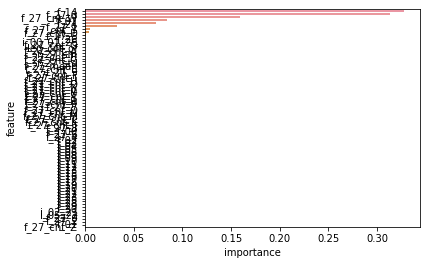

In [ ]:
importance = pd.DataFrame()
importance['feature'] = df_train[all_features].columns
importance['importance'] = model.feature_importances_

sns.barplot(x='importance', y='feature', data=importance.sort_values(by='importance', ascending=False))